# London Housing Prices
https://www.kaggle.com/alexkoziell/london-housing-prices

In [219]:
pip install pyspark

In [299]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('housing').getOrCreate()

from pyspark.sql.functions import isnan, when, count, col, udf, avg, max, sum
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [221]:
df_month = spark.read.csv('housing_in_london_monthly_variables.csv',inferSchema=True,header=True)
df_year = spark.read.csv('housing_in_london_yearly_variables.csv',inferSchema=True,header=True)

In [222]:
df_month.show(10)

+----------+--------------+-------------+---------+-----------+------------+------------+
|      date|          area|average_price|     code|houses_sold|no_of_crimes|borough_flag|
+----------+--------------+-------------+---------+-----------+------------+------------+
|1995-01-01|city of london|        91449|E09000001|         17|        null|           1|
|1995-02-01|city of london|        82203|E09000001|          7|        null|           1|
|1995-03-01|city of london|        79121|E09000001|         14|        null|           1|
|1995-04-01|city of london|        77101|E09000001|          7|        null|           1|
|1995-05-01|city of london|        84409|E09000001|         10|        null|           1|
|1995-06-01|city of london|        94901|E09000001|         17|        null|           1|
|1995-07-01|city of london|       110128|E09000001|         13|        null|           1|
|1995-08-01|city of london|       112329|E09000001|         14|        null|           1|
|1995-09-0

In [223]:
df_month.printSchema()

root
 |-- date: string (nullable = true)
 |-- area: string (nullable = true)
 |-- average_price: integer (nullable = true)
 |-- code: string (nullable = true)
 |-- houses_sold: integer (nullable = true)
 |-- no_of_crimes: double (nullable = true)
 |-- borough_flag: integer (nullable = true)



In [224]:
df_year.show(10)

+---------+--------------------+----------+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+------------+
|     code|                area|      date|median_salary|life_satisfaction|mean_salary|recycling_pct|population_size|number_of_jobs|area_size|no_of_houses|borough_flag|
+---------+--------------------+----------+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+------------+
|E09000001|      city of london|1999-12-01|        33020|             null|      48922|            0|           6581|          null|     null|        null|           1|
|E09000002|barking and dagenham|1999-12-01|        21480|             null|      23620|            3|         162444|          null|     null|        null|           1|
|E09000003|              barnet|1999-12-01|        19568|             null|      23128|            8|         313469|          null|     null|        null|

In [225]:
df_year.printSchema()

root
 |-- code: string (nullable = true)
 |-- area: string (nullable = true)
 |-- date: string (nullable = true)
 |-- median_salary: string (nullable = true)
 |-- life_satisfaction: string (nullable = true)
 |-- mean_salary: string (nullable = true)
 |-- recycling_pct: string (nullable = true)
 |-- population_size: integer (nullable = true)
 |-- number_of_jobs: double (nullable = true)
 |-- area_size: integer (nullable = true)
 |-- no_of_houses: integer (nullable = true)
 |-- borough_flag: integer (nullable = true)



In [226]:
# Keep London area only
df_month = df_month.filter(df_month.borough_flag == 1)
df_year = df_year.filter(df_year.borough_flag == 1)

In [227]:
# df month extract year and drop useless columns
keep_year = udf(lambda x: x.split('-')[0])
df_month = df_month.withColumn('year',keep_year(df_month.date))
df_month = df_month.drop('date','area','borough_flag')
df_year = df_year.withColumn('year',keep_year(df_year.date))
df_year = df_year.drop('date','area','borough_flag')

## Df month

In [228]:
# df month grouped by year and code
df_month_by_year = df_month.groupBy('year','code').agg(
    sum('houses_sold').alias('sum_houses_sold'),
    sum('no_of_crimes').alias('sum_no_of_crimes'),
    avg('average_price').alias('avg_price_by_year')
    ).orderBy('year')

In [229]:
df_month_by_year.tail(5)

[Row(year='2020', code='E09000021', sum_houses_sold=None, sum_no_of_crimes=1124.0, avg_price_by_year=483250.0),
 Row(year='2020', code='E09000022', sum_houses_sold=None, sum_no_of_crimes=2913.0, avg_price_by_year=526690.0),
 Row(year='2020', code='E09000030', sum_houses_sold=None, sum_no_of_crimes=2748.0, avg_price_by_year=450669.0),
 Row(year='2020', code='E09000018', sum_houses_sold=None, sum_no_of_crimes=2268.0, avg_price_by_year=412352.0),
 Row(year='2020', code='E09000031', sum_houses_sold=None, sum_no_of_crimes=2074.0, avg_price_by_year=452299.0)]

In [230]:
# Count null values in df_month
df_month_by_year.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_month_by_year.columns]).show()

+----+----+---------------+----------------+-----------------+
|year|code|sum_houses_sold|sum_no_of_crimes|avg_price_by_year|
+----+----+---------------+----------------+-----------------+
|   0|   0|             34|             209|                0|
+----+----+---------------+----------------+-----------------+



In [231]:
# Number of null values on crime by year
df_month_by_year.select(['year','sum_no_of_crimes']) \
    .filter(df_month_by_year.sum_no_of_crimes.isNull()) \
    .groupBy('year').count() \
    .orderBy('year').show()

+----+-----+
|year|count|
+----+-----+
|1995|   33|
|1996|   33|
|1997|   33|
|1998|   34|
|1999|   33|
|2000|   33|
|2011|    1|
|2012|    1|
|2013|    1|
|2014|    1|
|2015|    1|
|2016|    1|
|2017|    1|
|2018|    1|
|2019|    1|
|2020|    1|
+----+-----+



In [232]:
# Number of null values on sum_houses_sold by year
df_month_by_year.select(['year','sum_houses_sold']) \
    .filter(df_month_by_year.sum_houses_sold.isNull()) \
    .groupBy('year').count() \
    .orderBy('year').show()

+----+-----+
|year|count|
+----+-----+
|1998|    1|
|2020|   33|
+----+-----+



In [233]:
# Row drop before 2001 and == 2020 on the 2 df
df_month_by_year = df_month_by_year.filter((df_month_by_year.year > 2000) & (df_month_by_year.year != 2020))
df_year = df_year.filter((df_year.year > 2000) & (df_year.year != 2020))

# Replace remaining with mean
avg_crime = df_month_by_year.select(mean(df_month_by_year.sum_no_of_crimes)).collect()
avg_crime = avg_crime[0][0]
df_month_by_year = df_month_by_year.na.fill(avg_crime,subset=['sum_no_of_crimes'])

In [234]:
# Count missings
df_month_by_year.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_month_by_year.columns]).show()

+----+----+---------------+----------------+-----------------+
|year|code|sum_houses_sold|sum_no_of_crimes|avg_price_by_year|
+----+----+---------------+----------------+-----------------+
|   0|   0|              0|               0|                0|
+----+----+---------------+----------------+-----------------+



## Df year

In [235]:
df_year.printSchema()

root
 |-- code: string (nullable = true)
 |-- median_salary: string (nullable = true)
 |-- life_satisfaction: string (nullable = true)
 |-- mean_salary: string (nullable = true)
 |-- recycling_pct: string (nullable = true)
 |-- population_size: integer (nullable = true)
 |-- number_of_jobs: double (nullable = true)
 |-- area_size: integer (nullable = true)
 |-- no_of_houses: integer (nullable = true)
 |-- year: string (nullable = true)



In [236]:
df_year = df_year.withColumn('median_salary', df_year.median_salary.cast(IntegerType()))
df_year = df_year.withColumn('life_satisfaction', df_year.life_satisfaction.cast(FloatType()))
df_year = df_year.withColumn('mean_salary', df_year.mean_salary.cast(IntegerType()))
df_year = df_year.withColumn('recycling_pct', df_year.recycling_pct.cast(IntegerType()))

In [237]:
# Count missings
df_year.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_year.columns]).show()

+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+----+
|code|median_salary|life_satisfaction|mean_salary|recycling_pct|population_size|number_of_jobs|area_size|no_of_houses|year|
+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+----+
|   0|           10|              371|          5|           33|             33|            33|       33|          33|   0|
+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+----+



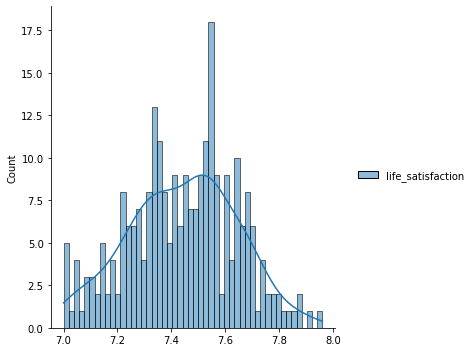

In [238]:
# Distribution of life_satisfaction
sns.displot(
    data=df_year.select('life_satisfaction').toPandas(),
    bins=50,
    kde=True)

In [239]:
# Number of null values on crime by year
df_year.filter((df_year.recycling_pct.isNull()) \
               | (df_year.population_size.isNull()) \
               | (df_year.number_of_jobs.isNull()) \
               | (df_year.area_size.isNull()) \
               | (df_year.no_of_houses.isNull()) \
               ).groupBy('year').count().orderBy('year').show()

+----+-----+
|year|count|
+----+-----+
|2019|   33|
+----+-----+



In [244]:
# No yearly data in 2019. Remove 2019 and replace other features by avg
avg_median_salary = df_year.select(mean(df_year.median_salary)).collect()
avg_median_salary = avg_median_salary[0][0]

avg_life_satisfaction = np.mean([float(str(i[0])) for i in df_year.select('life_satisfaction').collect() if str(i[0]) not in ['nan','None']])

avg_mean_salary = df_year.select(mean(df_year.mean_salary)).collect()
avg_mean_salary = avg_mean_salary[0][0]

df_year = df_year.na.fill(avg_median_salary,subset=['median_salary'])
df_year = df_year.na.fill(avg_life_satisfaction,subset=['life_satisfaction'])
df_year = df_year.na.fill(avg_mean_salary,subset=['mean_salary'])

df_month_by_year = df_month_by_year.filter(df_month_by_year.year != 2019)
df_year = df_year.filter(df_year.year != 2019)

In [245]:
# Count missings
df_year.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_year.columns]).show()

+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+----+
|code|median_salary|life_satisfaction|mean_salary|recycling_pct|population_size|number_of_jobs|area_size|no_of_houses|year|
+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+----+
|   0|            0|                0|          0|            0|              0|             0|        0|           0|   0|
+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+----+



## Join 2 datasets and predict average house price

In [246]:
df = df_year.join(df_month_by_year, ['year','code'], how='left')
df = df.withColumn('year', df.year.cast(IntegerType()))
df.show(5)

+----+---------+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+---------------+----------------+------------------+
|year|     code|median_salary|life_satisfaction|mean_salary|recycling_pct|population_size|number_of_jobs|area_size|no_of_houses|sum_houses_sold|sum_no_of_crimes| avg_price_by_year|
+----+---------+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+---------------+----------------+------------------+
|2001|E09000001|        39104|         7.441367|      62819|            0|           7359|      339000.0|      315|        5009|            367|             0.0|250625.58333333334|
|2001|E09000002|        22323|         7.441367|      26050|            3|         165654|       54000.0|     3780|       68298|           3203|         20476.0|           88664.0|
|2001|E09000003|        20916|         7.441367|      26068|            8|         319481|     

In [247]:
# One hot encode area code
string_indexer = StringIndexer(inputCol='code', outputCol='code_indexed')
df = string_indexer.fit(df).transform(df).drop('code')

In [248]:
df.show(5)

+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+---------------+----------------+------------------+------------+
|year|median_salary|life_satisfaction|mean_salary|recycling_pct|population_size|number_of_jobs|area_size|no_of_houses|sum_houses_sold|sum_no_of_crimes| avg_price_by_year|code_indexed|
+----+-------------+-----------------+-----------+-------------+---------------+--------------+---------+------------+---------------+----------------+------------------+------------+
|2001|        39104|         7.441367|      62819|            0|           7359|      339000.0|      315|        5009|            367|             0.0|250625.58333333334|         0.0|
|2001|        22323|         7.441367|      26050|            3|         165654|       54000.0|     3780|       68298|           3203|         20476.0|           88664.0|         1.0|
|2001|        20916|         7.441367|      26068|            8|         319481|

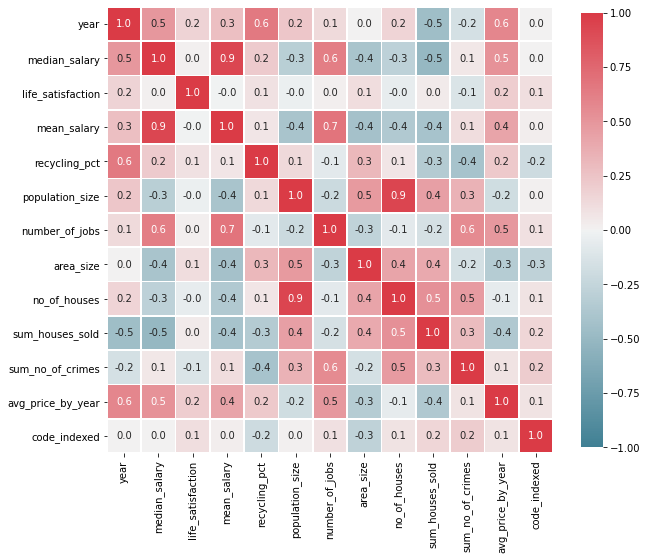

In [256]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    df.toPandas().corr(), 
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0, 
    center=0, 
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .8},
    annot=True,
    fmt='.1f'
)

## Regression

In [260]:
df = df.withColumnRenamed('avg_price_by_year','target')

In [307]:
# Split train set to a ml train set and a validation set
df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)

# Functions in the pipeline
evaluator = RegressionEvaluator(labelCol='target', metricName='r2')
assembler = VectorAssembler(inputCols=[c for c in df.columns if c != 'target'], outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
reg = RandomForestRegressor(featuresCol='scaledFeatures', labelCol='target')

# Definition of pipeline
pipeline_ml = Pipeline(stages=[assembler, scaler, reg])

# Definition of the grid parameters
paramGrid = ParamGridBuilder().\
            addGrid(reg.maxDepth, [2,5]).\
            addGrid(reg.numTrees, [50,100]).\
            build()

# Definition of the cross validator
cv = CrossValidator(
  estimator=pipeline_ml,
  estimatorParamMaps=paramGrid, 
  evaluator=evaluator, 
  numFolds=5)

# Train the model
model = cv.fit(df_train)

# Predict classes on test part
pred_ml_test = model.transform(df_test)

In [308]:
data = pred_ml_test.select(['target','prediction']).toPandas()
print('RMSE: {}'.format(round(np.sqrt(mean_squared_error(data.target, data.prediction)))))
print('r2: {}'.format(evaluator.evaluate(pred_ml_test)))

RMSE: 72865
r2: 0.8147952546881442


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 1300000.0)

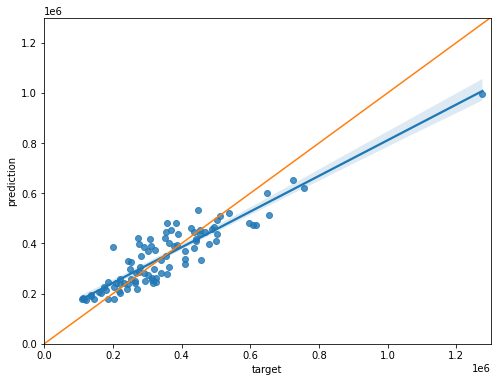

In [313]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(data = data, x='target', y='prediction')
sns.lineplot([0,1.3e6],[0,1.3e6])
plt.xlim(0,1.3e6)
plt.ylim(0,1.3e6)